# Supervised Model 2 - Neural Network
In this approach we train a neural network on encoded inputs of Ligand SMILES and Target Drug Sequence to try and predict the affinity between the two. It is a classic regression task where we are attempting to minimize the MSE between the predicted and actual values


## Prerequisites

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 45.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from rdkit import Chem
from rdkit.Chem import AllChem

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/EC50_bind.tsv', sep='\t')
data.head()

,drug_id,target_id,smiles,target_seq,origin_affinity,affinity
0,100000,P49862,CN1CCN(Cc2c(O)c(Cl)cc3c(cc(=O)oc23)-c2ccccc2)CC1,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...,68293,4.165624
1,100001,P49862,COc1ccccc1C1CC(=Nc2nnnn12)c1ccc(C)cc1,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...,23546,4.628083
2,100002,P49862,Cc1oc2c(CN3CCCC3)c(O)ccc2c(=O)c1-c1ccc(Br)cc1,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...,>69498,4.158021
3,100003,P49862,CCN1C(c2ccccn2)n2c(nc3ccccc23)-c2ccccc12,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...,>69511,4.157940
4,100004,P49862,Oc1ccc2c(occ(-c3ccc(Br)cc3)c2=O)c1CN1CCOCC1,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...,66092,4.179851


In [ ]:
# Convert SMILES to fingerprints
def smiles_to_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    else:
        return np.zeros((n_bits,))

# Convert sequences to amino acid composition
def sequence_to_composition(sequence):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    composition = [sequence.count(aa) / len(sequence) for aa in amino_acids]
    return np.array(composition)

data['Fingerprint'] = data['smiles'].apply(smiles_to_fingerprint)
data['Composition'] = data['target_seq'].apply(sequence_to_composition)

[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerator
[20:35:29] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
X_drug = [torch.tensor(fp, dtype=torch.float32).to(device) for fp in data['Fingerprint']]
X_target = [torch.tensor(comp, dtype=torch.float32).to(device) for comp in data['Composition']]
X = [(drug, target) for drug, target in zip(X_drug, X_target)]
y = torch.tensor(data['affinity'].values, dtype=torch.float32).to(device)

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

class AffinityDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def collate_fn(batch):
    drugs = [item[0][0] for item in batch]
    targets = [item[0][1] for item in batch]
    affinities = torch.tensor([item[1] for item in batch], dtype=torch.float32).to(device)

    return drugs, targets, affinities

dataset = AffinityDataset(X, y)
test_split_ratio = 0.2
test_size = int(len(dataset) * test_split_ratio)
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## Model Initialization

In [ ]:
import torch.nn as nn

class AffinityNN(nn.Module):
    def __init__(self):
        super(AffinityNN, self).__init__()
        self.drug_fc = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.target_fc = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.fc_combined = nn.Sequential(
            nn.Linear(128 + 64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, drugs, targets):
        drug_out = torch.stack([self.drug_fc(drug) for drug in drugs]).to(device)
        target_out = torch.stack([self.target_fc(target) for target in targets]).to(device)
        combined = torch.cat((drug_out, target_out), dim=1)
        output = self.fc_combined(combined)
        return output

In [ ]:
model = AffinityNN()
device = torch.device("cuda")
model.to(device)

AffinityNN(
  (drug_fc): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (target_fc): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc_combined): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(initialize_weights)

AffinityNN(
  (drug_fc): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (target_fc): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc_combined): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
best_model_path = "/content/drive/MyDrive/best_model.pth"
model.load_state_dict(torch.load(best_model_path))

<ipython-input-20-231d7c987ec3>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [ ]:
model.eval()
test_loss = 0.0

with torch.no_grad():
    for drugs, targets, affinities in test_dataloader:
        predictions = model(drugs, targets)
        loss = criterion(predictions.view(-1), affinities)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_dataloader)}")

Test Loss: 0.3757827891895431


# Inference

In [ ]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for drugs, targets, affinities in dataloader:
    drugs = [drug.to(device) for drug in drugs]
    targets = [target.to(device) for target in targets]
    affinities = affinities.to(device)

    with torch.no_grad():
        predictions = model(drugs, targets)

    predictions = predictions.view(-1).cpu().numpy()

    print(f"Predicted Affinities (Batch of {batch_size}):")
    print(predictions)

    true_affinities = affinities.cpu().numpy()
    print(f"True Affinities (Batch of {batch_size}):")
    print(true_affinities)

    break

Predicted Affinities (Batch of 32):
[ 5.6721287  8.013912   6.563008   6.6877275  7.140765   7.248355
  7.579259   5.966671  10.218059   7.5664716  7.4780703  4.950124
  5.7626405  6.353063   5.7212253  7.436429   7.4240775  6.6840944
  6.4713144  4.2432537  8.914692   5.07006    6.207715   7.756018
  8.041055   6.4963055  5.3365564  8.021536   6.977025   5.7144523
  7.046212   5.1844664]
True Affinities (Batch of 32):
[ 5.6575775  6.920819   6.         7.29243    8.2218485  8.39794
  7.6197886  6.        11.943095   7.853872   7.7447276  4.5228643
  6.496209   6.4202166  5.1639924  7.39794    7.6197886  6.537602
  6.4145393  4.124933   8.69897    5.5800443  6.500313   6.8416376
  8.420217   5.704873   5.055517   8.267606   6.4634414  5.3425617
  7.3279023  5.341321 ]


<ipython-input-22-afb6d0e32141>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


## Visualization
### Training Curve Loss VS. Epoch

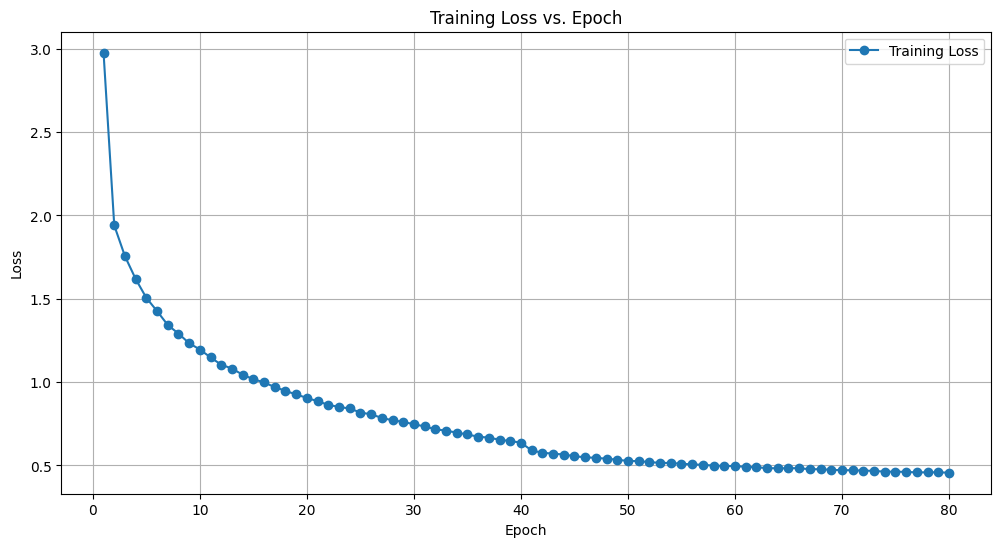

In [ ]:
import matplotlib.pyplot as plt

# Loss values for all 4*20 epochs from the logs provided
losses = [
    2.9766, 1.9402, 1.7555, 1.6190, 1.5055, 1.4265, 1.3429, 1.2914, 1.2336, 1.1958,
    1.1484, 1.1044, 1.0818, 1.0443, 1.0181, 0.9979, 0.9705, 0.9476, 0.9259, 0.9056,
    0.8854, 0.8640, 0.8509, 0.8421, 0.8175, 0.8072, 0.7853, 0.7711, 0.7616, 0.7472,
    0.7345, 0.7174, 0.7086, 0.6974, 0.6861, 0.6726, 0.6671, 0.6544, 0.6464, 0.6372,
    0.5902, 0.5764, 0.5709, 0.5658, 0.5553, 0.5493, 0.5456, 0.5408, 0.5344, 0.5271,
    0.5263, 0.5201, 0.5159, 0.5149, 0.5105, 0.5065, 0.5039, 0.4992, 0.4976, 0.4964,
    0.4921, 0.4891, 0.4845, 0.4827, 0.4836, 0.4837, 0.4772, 0.4779, 0.4735, 0.4720,
    0.4711, 0.4691, 0.4677, 0.4626, 0.4630, 0.4614, 0.4583, 0.4590, 0.4591, 0.4565
]

# Create a list of epoch numbers
epochs = list(range(1, len(losses) + 1))

# Plot Loss vs Epoch
plt.figure(figsize=(12, 6))
plt.plot(epochs, losses, marker='o', label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.grid(True)
plt.legend()
plt.show()

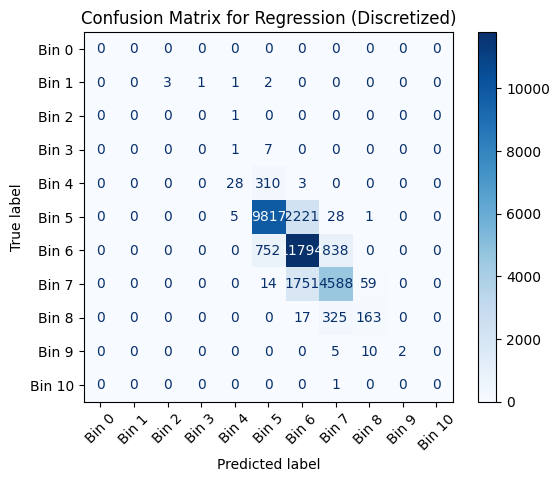

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Define bins for discretization
bins = np.linspace(min(y.cpu().numpy()), max(y.cpu().numpy()), num=11)  # Adjust bin count as needed

# Discretize true and predicted values
true_values = []
predicted_values = []

with torch.no_grad():
    for drugs, targets, affinities in test_dataloader:
        predictions = model(drugs, targets).view(-1).cpu().numpy()
        true_values.extend(affinities.cpu().numpy())
        predicted_values.extend(predictions)

true_bins = np.digitize(true_values, bins)
predicted_bins = np.digitize(predicted_values, bins)

# Compute confusion matrix
cm = confusion_matrix(true_bins, predicted_bins, labels=range(len(bins)))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Bin {i}' for i in range(len(bins))])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix for Regression (Discretized)')
plt.show()

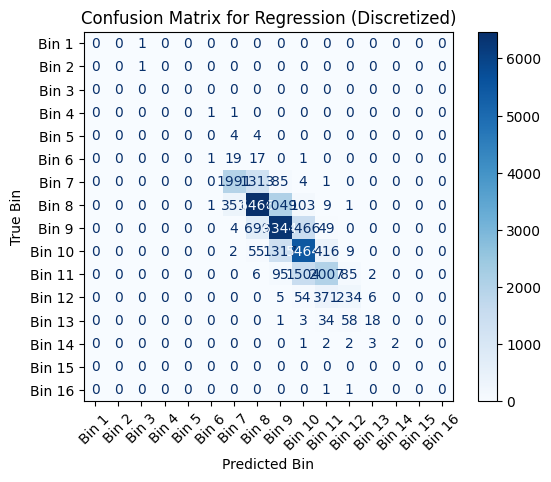

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Define bins for discretization
num_bins = 17  # Adjust the number of bins as needed
bins = np.linspace(min(y.cpu().numpy()), max(y.cpu().numpy()), num=num_bins)  # Bin edges

# Discretize true and predicted values
true_values = []
predicted_values = []

with torch.no_grad():
    for drugs, targets, affinities in test_dataloader:
        predictions = model(drugs, targets).view(-1).cpu().numpy()
        true_values.extend(affinities.cpu().numpy())
        predicted_values.extend(predictions)

# Convert true and predicted values to bins
true_bins = np.digitize(true_values, bins, right=True) - 1  # Align bin indices to 0-based indexing
predicted_bins = np.digitize(predicted_values, bins, right=True) - 1

# Validate arrays
if len(true_values) == 0 or len(predicted_values) == 0:
    raise ValueError("True values or predicted values are empty. Check the test_dataloader or model predictions.")

# Compute confusion matrix
cm = confusion_matrix(true_bins, predicted_bins, labels=range(num_bins - 1))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Bin {i+1}' for i in range(num_bins - 1)])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix for Regression (Discretized)')
plt.xlabel('Predicted Bin')
plt.ylabel('True Bin')
plt.show()